In [75]:
import nltk, re, os
import numpy as np
from matplotlib import pyplot as plt
from nltk.tokenize import texttiling, sent_tokenize
from nltk.corpus import brown

### TextTiling

In [3]:
test_text = brown.raw()[:1000]
tt_en = texttiling.TextTilingTokenizer(demo_mode=False)
# tt_en.tokenize(test_text)

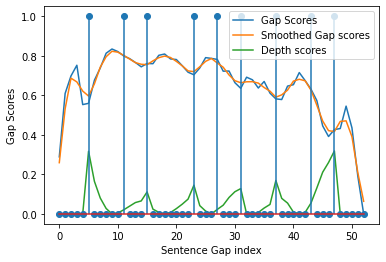

In [2]:
texttiling.demo()

#### Grab text

In [136]:
def clean_text(text):
    """
    Removes lines starting with "===" from string.
    Replace \n with \n\n (for nltk).
    """
    t = re.sub(r'^(?:(<doc)|(<\/doc)).*\n', '', text, flags=re.MULTILINE)
    t = re.sub(r'^===.*\n', '', t, flags=re.MULTILINE)
    return re.sub('\n','\n\n', t) 

def get_truth(text: str):
    t = re.sub(r'^(?:(<doc)|(<\/doc)).*\n', '', text, flags=re.MULTILINE)
    t_sep = sent_tokenize(t)
    return [1 if s.startswith('===') else 0 for s in t_sep]

def plot(s, ss, d, b, ground_truth):
    """
    Inspired by texttiling.demo()
    """
    ground_truth = np.array(ground_truth)
    fig, ax = plt.subplots(figsize=(20,5),)
    ax.set_xlabel("Sentence Gap index")
    ax.set_ylabel("Gap Scores")
    ax.set_ylim(-0.1, 1.1)
    ax.plot(range(len(s)), s, label="Gap Scores", color='b')
    ax.plot(range(len(ss)), ss, label="Smoothed Gap scores", color='g')
    ax.plot(range(len(d)), d, label="Depth scores", color='y')
    ax.vlines(range(len(ground_truth)), ymin=-0.1*ground_truth, ymax=1.1*ground_truth, color='r', label="Ground Truth")
    _, _, baseline = ax.stem(range(len(b)), b, linefmt='--', markerfmt=' ', label="Predicted boundaries")
    plt.setp(baseline, color='k', alpha=0.5)
    ax.legend()
    fig.show()

In [124]:
with open('../NLWiki/AA/wiki_02', 'r') as file:
    nl_text = file.read()
nl_text_clean = clean_text(nl_text)

In [139]:
tt = texttiling.TextTilingTokenizer(demo_mode=True, stopwords=nltk.corpus.stopwords.words('dutch'))
res = tt.tokenize(nl_text_clean)

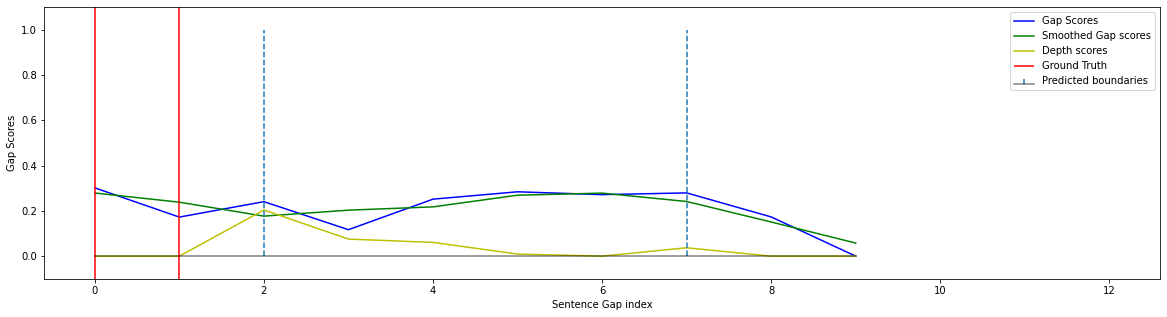

In [137]:
plot(*res, get_truth(nl_text))

In [130]:
t = re.sub(r'^(?:(<doc)|(<\/doc)).*\n', '', nl_text, flags=re.MULTILINE)
len(sent_tokenize(t))

13

In [138]:
len(sent_tokenize(nl_text_clean))

13

In [131]:
tt2 = texttiling.TextTilingTokenizer(stopwords=nltk.corpus.stopwords.words('dutch'))
segs = tt2.tokenize(nl_text_clean)
for s in segs:
    print(s)



Albert Plesman ('s-Gravenhage, 7 september 1889 – aldaar, 31 december 1953) was een Nederlands luchtvaartpionier en de eerste president-directeur van de KLM.

Plesman werd geboren als zoon van een eierenhandelaar te 's-Gravenhage. Toen Plesman dertien jaar oud was, overleed zijn moeder.


Hij trouwde op 27 december 1917 met Susanna Jacoba (Suus) van Eijk (1895–1974), dochter van een kaasfabrikant te Gouda. Uit dit huwelijk werden een dochter en drie zoons geboren.

Plesman was in 1915 gelegerd te Soesterberg, waar hij als beroepsofficier bij de gemobiliseerde "Luchtvaartafdeeling der Koninklijke Landmacht" (LVA) in 1918 zijn militaire vliegbrevet behaalde.

Plesman was mede-organisator van de Eerste Luchtverkeer Tentoonstelling Amsterdam die van 1 augustus tot 14 september 1919 gehouden werd. Er kwamen 800.000 bezoekers op af. Voor deze gelegenheid waren expositiehallen gebouwd, die na het evenement in gebruik werden genomen door Anthony Fokker, voor zijn nieuw op te richten "Nederla